# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
idx = pd.IndexSlice
%matplotlib inline


# Prepare the training dataframe and universe selection

In [2]:
# Import price and volume time series of the primary equities we'll be forecasting.
prices_import=pd.read_csv("train_files/stock_prices.csv", parse_dates=['Date'])
prices =prices_import.rename({'SecuritiesCode':'Code'}, axis = 1).set_index(keys = ['Code', 'Date']).sort_index().copy()
print("The train data begins on {} and ends on {}.\n".format(prices_import.Date.min(),prices_import.Date.max()))
display(prices_import.describe().style.format('{:,.2f}'))

# Imoprt a dataframe about the tags and characteristics of a stock (i.e it's sector and market segment)
stock_list=pd.read_csv("stock_list.csv")
stock_list = stock_list.rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')


dates = prices.index.get_level_values(1).unique()
securities = prices.index.get_level_values(0).unique()

# Import prices from the secondary data frame
# This data frame will contain the market index we'll use to compute a stock's beta.
secondary_prices_import = pd.read_csv('train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices_import.Date = pd.to_datetime(secondary_prices_import.Date)
secondary_prices_import = secondary_prices_import.set_index(['Code', 'Date']).sort_index()

The train data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,"2,332,531.00","2,332,531.00","2,324,923.00","2,324,923.00","2,324,923.00","2,324,923.00","2,332,531.00","2,332,531.00","18,865.00","2,332,293.00"
mean,",.2f","5,894.84","2,594.51","2,626.54","2,561.23","2,594.02","691,936.56",1.00,22.02,0.00
min,",.2f","1,301.00",14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,",.2f","3,891.00","1,022.00","1,035.00","1,009.00","1,022.00","30,300.00",1.00,5.00,-0.01
50%,",.2f","6,238.00","1,812.00","1,834.00","1,790.00","1,811.00","107,100.00",1.00,15.00,0.00
75%,",.2f","7,965.00","3,030.00","3,070.00","2,995.00","3,030.00","402,100.00",1.00,30.00,0.01
max,",.2f","9,997.00","109,950.00","110,500.00","107,200.00","109,550.00","643,654,000.00",20.00,"1,070.00",1.12
std,nan,"2,404.16","3,577.19","3,619.36","3,533.49","3,576.54","3,911,255.94",0.07,29.88,0.02


In [3]:
stock_list['Section/Products'].value_counts()

Section/Products
First Section (Domestic)                                       2327
JASDAQ(Standard / Domestic)                                     726
Second Section(Domestic)                                        530
Mothers (Domestic)                                              439
ETFs/ ETNs                                                      277
REIT, Venture Funds, Country Funds and Infrastructure Funds      68
JASDAQ(Growth/Domestic)                                          41
First Section (Foreign)                                           4
Mothers (Foreign)                                                 3
JASDAQ(Standard / Foreign)                                        1
Second Section(Foreign)                                           1
Name: count, dtype: int64

In the complete stock list there's a wide variety of securities.  We'll look in the `prices` dataframe once the universe has been filtered to see what type of equities we're working with.

## Filter out late IPOs
Stocks that IPO'd in the middle of the time period of the dataset won't be trained on

In [4]:
# Check if each security has a complete date set
date_set = (prices.groupby('Code', group_keys=False).apply(lambda x: dates.isin(x.index.get_level_values(1)).all()))
bad_securities = date_set[~date_set].index
good_securities = date_set[date_set].index

prices = prices.loc[good_securities].copy()

## Appending the market index 
The market index I'll use is NIKKEI 400 which corresponds to securities code:1592.  It's located in the secondary prices dataset.

Text(0.5, 1.0, 'Nikkei 400 index ETF\nSecurity code 1592')

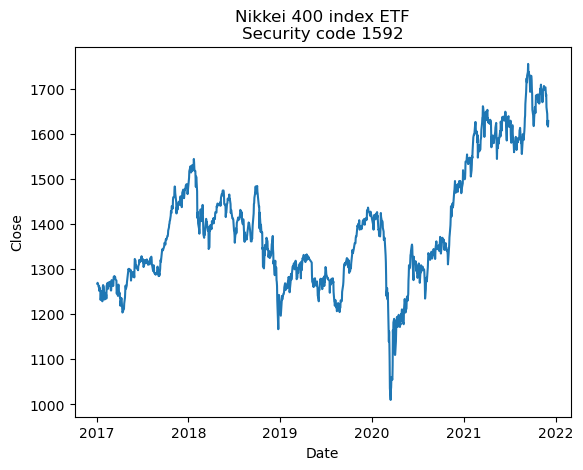

In [5]:
# Security code 1592 is a good approximatin to the Nikkei 225 index
prices = pd.concat([prices, secondary_prices_import.loc[idx[1592, :],:]]).sort_index()

fig, ax = plt.subplots()
sns.lineplot(data = prices.loc[1592], x='Date', y='Close')
ax.set_title('Nikkei 400 index ETF\nSecurity code 1592')

<!-- ## Merging fundamental data
not working at the moment because of forecast revisions -->

## Filtering out bad days
There was a bizarre computer outage on 2020-10-01 in the JPY exchange, so that day will get thrown out from the training data set.


In [6]:
train = prices.copy()
train_dup = train.index[train.index.duplicated()]
train = train[train.index.get_level_values(1) != '2020-10-01']

# for entries with no volume, make the OHLC the previous days close
# It might make sense to throw these training examples out since there's no actvitiy here
no_volume = train['Volume'] ==0
# train['Close'] =train.groupby('Code')['Close'].bfill()
# train.loc[no_volume, ['Open', 'High', 'Low']] = train.loc[no_volume, 'Close']

In [7]:
universe_list = train.index.get_level_values('Code').drop_duplicates().to_list()
stock_list.loc[universe_list, 'Section/Products'].value_counts()

Section/Products
First Section (Domestic)       1646
JASDAQ(Standard / Domestic)     103
Second Section(Domestic)         85
Mothers (Domestic)               24
JASDAQ(Growth/Domestic)           7
ETFs/ ETNs                        1
Name: count, dtype: int64

## Universe selection conclusion
* It looks we've constrained our universe to be Japanese businesses.  The only ETF that is included in the universe list should be the Nikkei 400 ETF that we intentionally included to act as our market index. 

# Calculating $\beta$

$$
\beta_e = \frac{\text{Cov}(R_{e}, R_{m})}{\text{Var}(R_m)}
$$
* $\beta_e$ explains the contribution of volatility in an equity that is derived from the systematic risk in the overall market.
* $R_e$ is the daily return of a stock price.
* $R_m$ is the daily return in a market index.

An appropriate estimator for the covariance of two random variables would be

$$
\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n}{ \left(X_i - \bar{X}\right) \left(Y_i - \bar{Y}\right)}
$$

Where $\bar{X}$ is the estimator for the mean of $X$.  Estimators for covariance and mean should converge to their true population statistic by WLLN.  If we set $n=45$ and using a moving average approach, we can compute the 45 day $\beta$.

Targets:
* Forecast the 45 day average $beta$ for the next day
* Forecast the 45 day average $beta$ 45 days from now
 
 Checking the autocorrelation of the $\beta$ would indicate how hard it is to forecast $\beta$ far into the future.

 Note $\beta$ is also the coefficient if we regress the stock returns against the market returns (and so could be computed from matrix multiplication and inversion of $A^TA$).


In [8]:
# Use the adjusted close and volume to compute the beta
train['AdjClose'] =train.groupby('Code', group_keys=False).apply(
    lambda x: x['Close'] * (x['AdjustmentFactor'].cumprod()))
train['AdjVolume'] =train.groupby('Code', group_keys=False).apply(
    lambda x: x['Volume'] / (x['AdjustmentFactor'].cumprod()))
train['DollarVolume'] = train['AdjClose'] * train['AdjVolume']

# there are some bad reporting days that cause 
# the returns to be incorrect.
# In the original kaggle challenge the target was 
# returns shifted ahead by 2 days, so I'll just 
# shift those back by 2.
train['returns'] = train.groupby('Code', group_keys=False)['Target'].shift(2)
train['returns_target'] = train.groupby('Code', group_keys=False)['Target'].shift(1)
# train['returns'] = train.groupby('Code', group_keys=False)['AdjClose'].apply(lambda x: x.pct_change())
train['cum_return'] = train.groupby('Code', group_keys=False)['returns'].apply(lambda x: (1+x).cumprod())

market_df = train.loc[1592]

* `beta_45avg` is computed using 45 days of returns of a stock and the market.  This is a "historical" beta that depends on data that has been recorded.
* `beta_45avg_1` would be tomorrow's 45 day averaged beta.  We should expect this time series to have strong correlation with the historical `beta_45avg` because only 1/45 days is unknown to us, and is likely to have weak contribution in comparison to the other 44 days.
* A natural thing to check would be the autocorrelation.

In [9]:
# forecast window
target_window_span = 45
# forward_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=target_window_span)

def wavelet_smooth(signal, threshold = 0.2, level =3, wavelet = 'db6'):

    coeff = pywt.wavedec(signal, wavelet, mode = 'per', level =level)
    coeff[1:]  = [pywt.threshold(i, value=threshold*np.abs(signal.max()), mode = 'soft') for i in coeff[1:]]
    clean_signal = pywt.waverec(coeff, wavelet, mode = 'per')
    # return clean_signal
    if len(signal)%2 == 1:
        clean_series= pd.Series(clean_signal[:-1], signal.index)
    else:
        clean_series =  pd.Series(clean_signal, signal.index)
    return clean_series

def rolling_beta(df:pd.DataFrame, rolling_window, column, market_df=market_df):
    Y_series= df[column]
    X_series = market_df[column]
    XY_series = X_series * Y_series
    XY_mean = XY_series.rolling(window=rolling_window).mean()
    X_mean = X_series.rolling(window=rolling_window).mean()
    Y_mean = Y_series.rolling(window=rolling_window).mean()
    X_variance = X_series.rolling(window=rolling_window).var()
    return (XY_mean - X_mean * Y_mean) / X_variance


train['beta_45avg']=train.groupby('Code', group_keys=False).apply(
    rolling_beta, rolling_window=target_window_span, column='returns'
)

# we use ffill to populate time series who's values we are unsure of.
# bfill would constitute a lookahead bias, who's severity would depend on 
# the span of the averaging window.
train['beta_target_1'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-1).ffill()
train['beta_target_5'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-5).ffill()
train['beta_target_20'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-20).ffill()
train['beta_target_45'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-45).ffill()

beta_autocorrelation = np.array([
    train['beta_45avg'].autocorr(i) for i in range (1, 91)
])
# OLD CODE
# train['beta_target']=train['beta_target_45']
# train['dbeta'] = train.groupby('Code', group_keys=False)['beta_target'].apply(lambda x: x.diff().fillna(x.diff().mean()))
# train['dbeta_sm']=train.groupby('Code', group_keys = False)['dbeta'].apply(wavelet_smooth, level = 4, threshold = 0.15)


## Analyze a few $\beta$ time series
* To give some confidence we've computed the $\beta$ correctly, we might just look at their time series for a few stocks.  
* We'll look at the top 3 beta stocks, the median 3 beta stocks, and the 3 lowest $\beta$ stocks.

In [10]:
sec_stats = pd.DataFrame(index = train.index.get_level_values(0).unique())
sec_stats['avg_beta'] = train.groupby('Code', group_keys=False)['beta_45avg'].mean()
sec_stats['beta_rank'] = np.abs(sec_stats.avg_beta).rank(ascending = False)
sec_stats.sort_values(by = 'beta_rank',inplace=True)

top3_betas = sec_stats.head(3).index.get_level_values('Code').to_list()
bottom3_betas = sec_stats.tail(3).index.get_level_values('Code').to_list()

median_betas = sec_stats.loc[sec_stats['avg_beta'].between(
    sec_stats['avg_beta'].quantile(0.499),
    sec_stats['avg_beta'].quantile(0.501),
)].index.get_level_values('Code').to_list()

def plot_target_timeseries(tickers:list, targets:list=None, df:pd.DataFrame =None):
    if df ==None: df =  train
    if targets == None: targets = ['beta_45avg']
    targets = ['cum_return'] + targets

    fig, ax = plt.subplots(len(tickers), len(targets), figsize = (14,10))
    for i, tick in enumerate(tickers):
        ax[i, 0].set_title('Security code {:}'.format(tick))
        ax[i, 1].set_title('beta rank {:}\n mean beta={:.3g}'.format(*sec_stats.loc[tick, ['beta_rank', 'avg_beta']]))
        for j, targ in enumerate(targets):
            sns.lineplot(df.loc[tick], x= 'Date', y = targ, ax = ax[i, j])

    fig.tight_layout()

### Top 3 high $\beta$ stocks

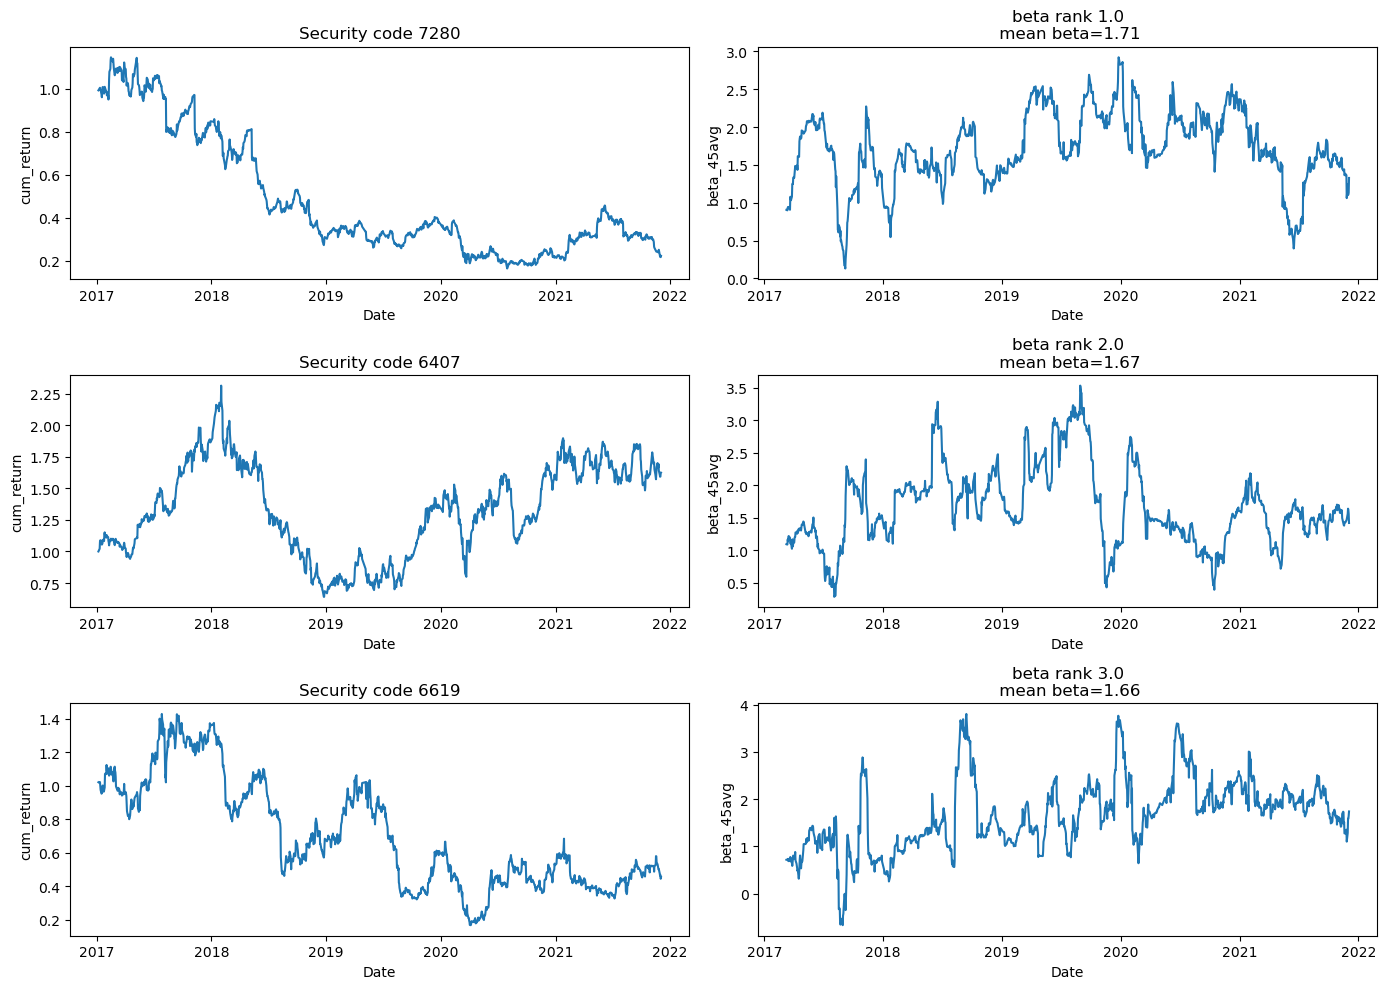

In [11]:
plot_target_timeseries(top3_betas, ['beta_45avg'])
# plot_target_timeseries(top3_alphas)

### Median $\beta$ stocks

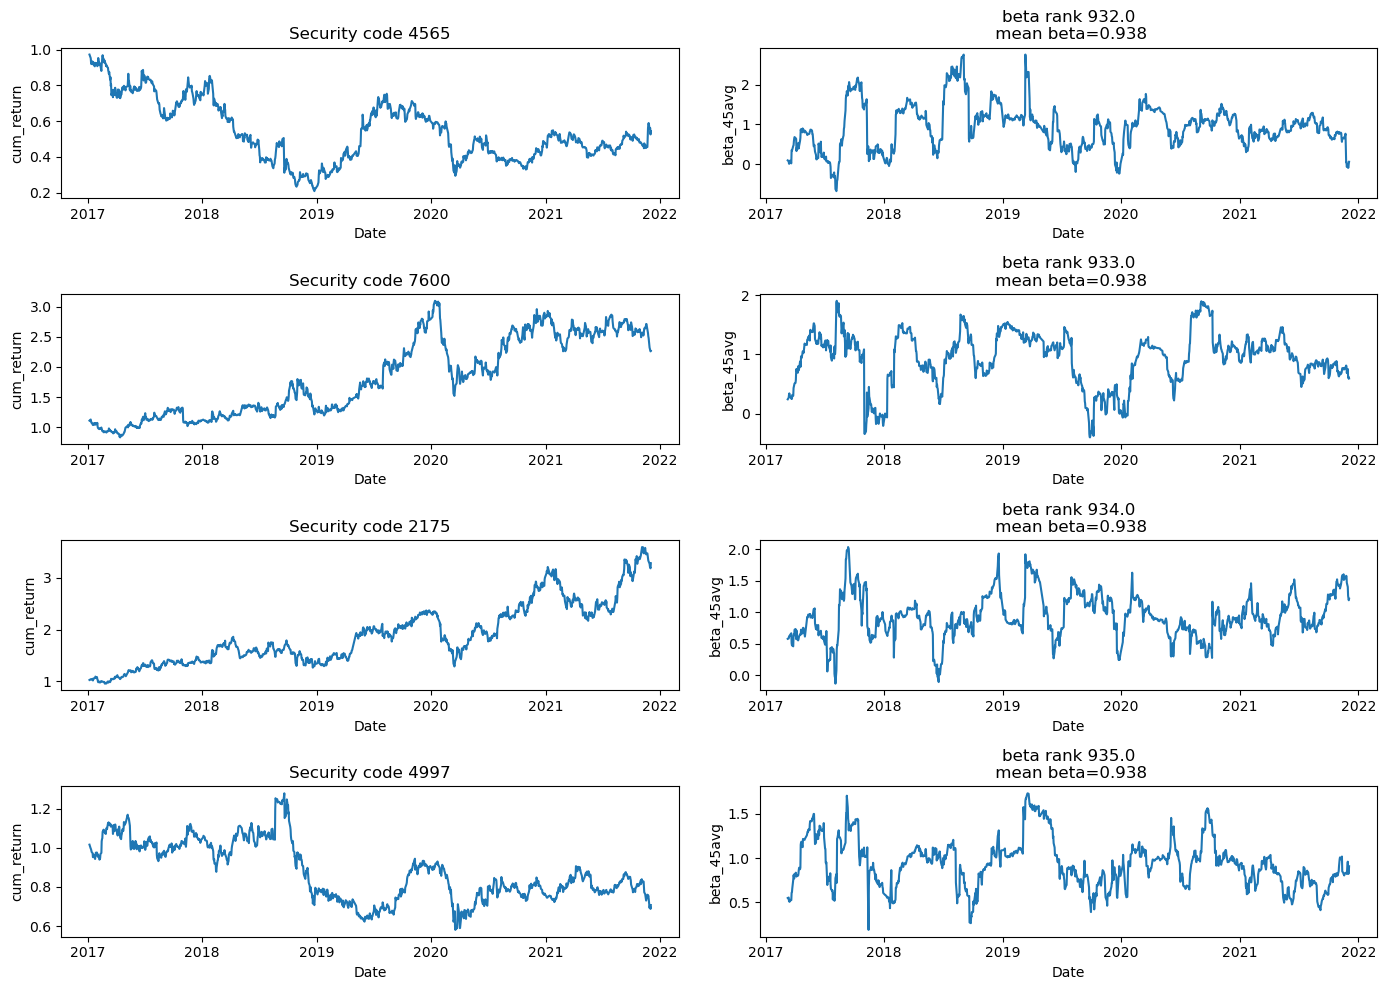

In [12]:
plot_target_timeseries(median_betas, ['beta_45avg'])

### Bottom 3 $\beta$ stocks

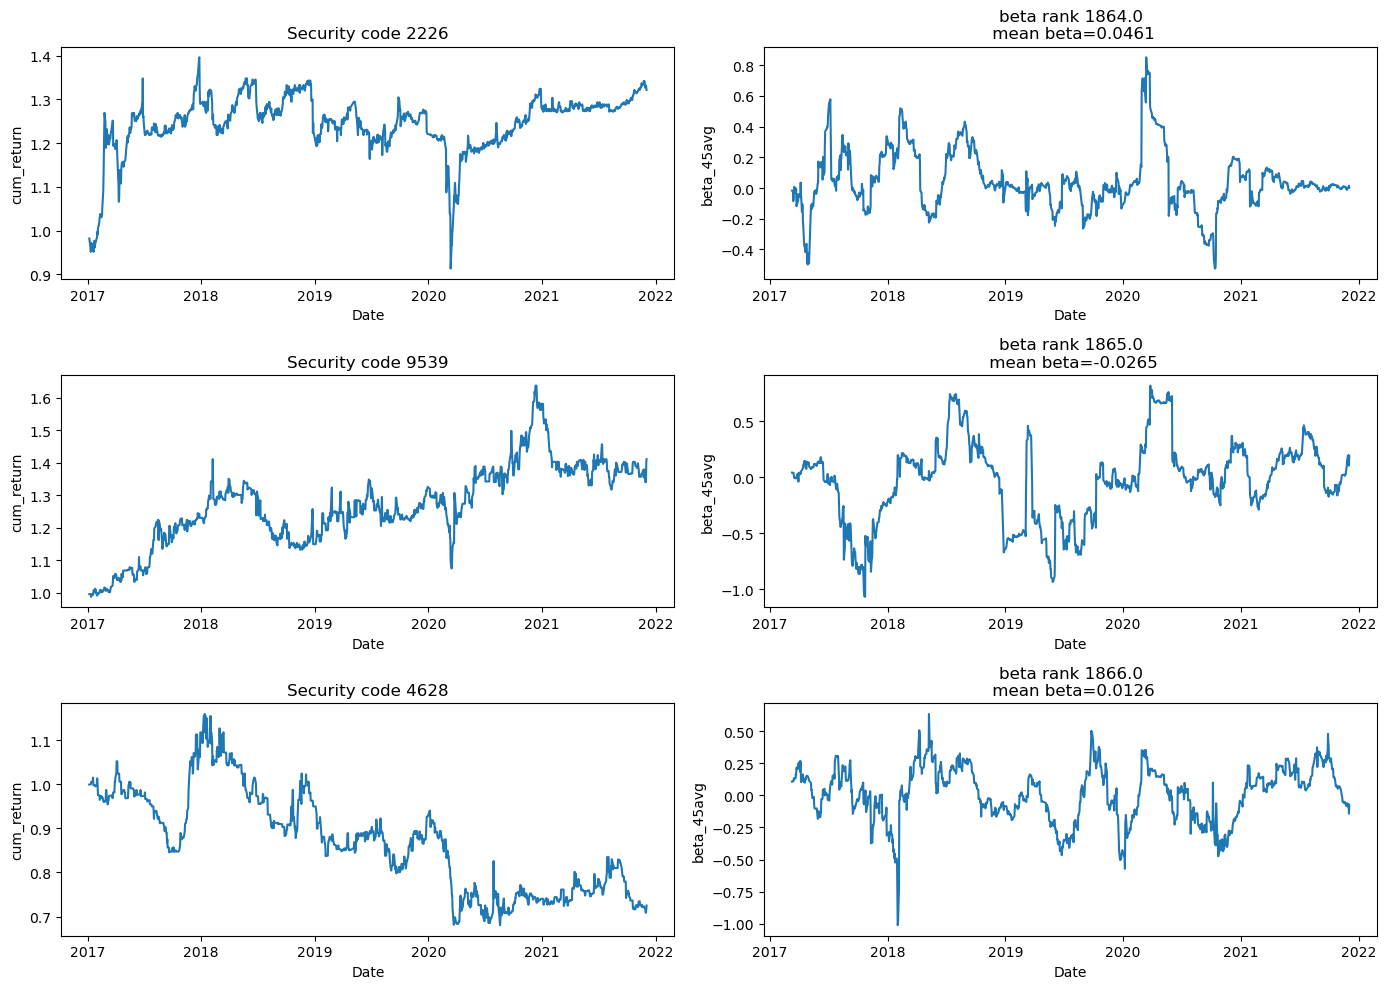

In [13]:
plot_target_timeseries(bottom3_betas, ['beta_45avg'])

<font size = 4>

* Seems a little strange that low beta stocks have outperformed some mid tier beta stocks (i.e. security 9539 in the bottom tier has outperformed 4997 in the mid tier).  But this is just few particular examples so it seems possible. 
* There seems to be no evidence that $\beta$ was incorrectly computed so I will continue with feature engineering.

### Distribution of betas

<Axes: xlabel='avg_beta', ylabel='Count'>

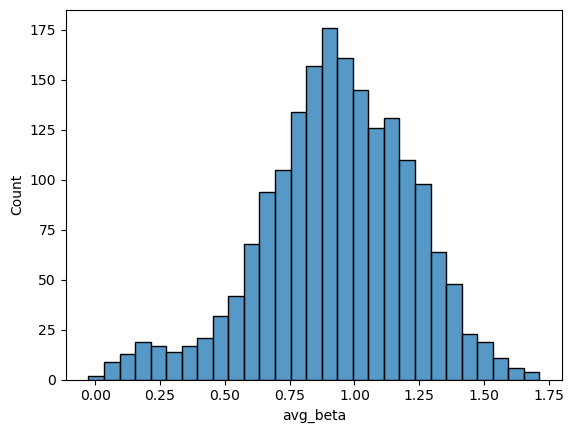

In [14]:
fig, ax = plt.subplots()
sns.histplot(sec_stats, x='avg_beta')

<font size = 4>

* Seems like there's a small mode of low beta equities in the dataset

## Autocorrelation in the 45 day $\beta$

$$
\rho(k) = \frac{ \text{Cov}(X_t, X_{t-k}) } { \text{Var}(X_t) }
$$

Where $\rho(k)$ is a measure of how correlated a time series is with itself, but lagged by a period of $k$

Text(0, 0.5, 'Autocorrelation')

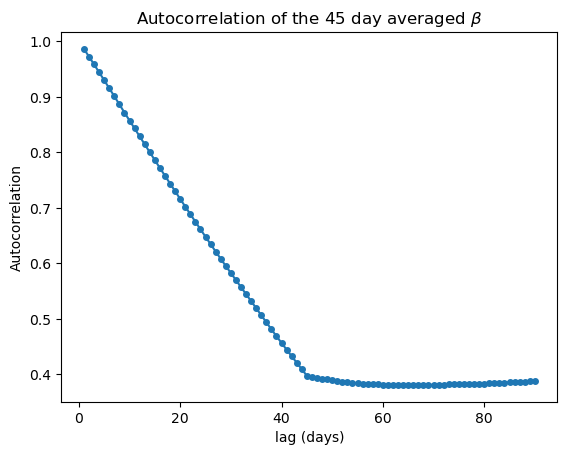

In [15]:
# train['beta_45avg'].autocorr(4)
fig, ax = plt.subplots()
ax.plot(np.arange(1, 91),beta_autocorrelation, 'o-', markersize = 4)
ax.set_title(r'Autocorrelation of the 45 day averaged $\beta$ ')
ax.set_xlabel(r'lag (days)')
ax.set_ylabel(r'Autocorrelation')

# ax.axhline(0.7, color='k', linestyle='--')

* The broad minimum near the 65 day lag seems a little strange, but the fact that it's extremely broad makes me less concerned.

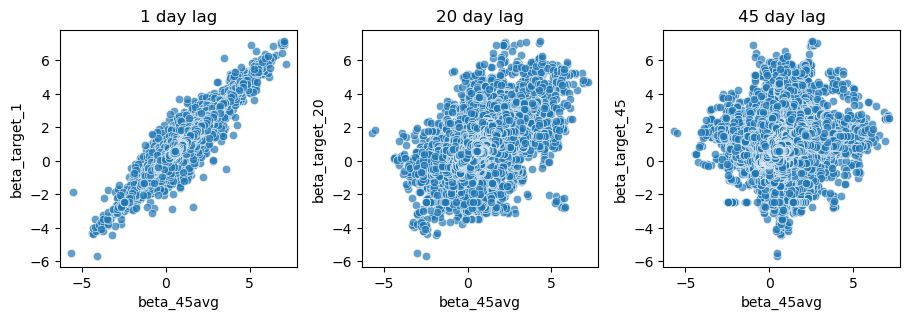

In [16]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize = (9.2, 5.6))


sns.scatterplot(train, x='beta_45avg', y='beta_target_1' , alpha = 0.7, ax=ax[0]) 
sns.scatterplot(train, x='beta_45avg', y='beta_target_20',  alpha = 0.7, ax=ax[1])
sns.scatterplot(train, x='beta_45avg', y='beta_target_45',  alpha = 0.7, ax=ax[2])

ax[0].set_title('1 day lag')
ax[1].set_title('20 day lag')
ax[2].set_title('45 day lag')
for a in ax: a.set_aspect('equal')

* The autocorrelation seems to plateau past a lag of ~42 periods.  
* Forecasting the 45 day average $\beta$, 45 days from now seems to be as tough as it gets.

This qualitatively makes a lot of sense. If the lag, $k$ is less than the window span, then I don't really have to forecast a 45 day statistic, I only have to forecast a statistic over the span of $k$ days.


In [17]:
# FUNDAMENTAL DATA #
# still in progress

# fund_import = pd.read_csv('train_files/financials.csv').rename(columns ={'SecuritiesCode': 'Code'})
# fund_import = fund_import[~fund_import['Code'].isna()]
# fund_import['Code']=fund_import['Code'].astype(int)
# fund_import['Date'] = pd.to_datetime(fund_import['Date'])
# fund_import = fund_import.set_index(['Code', 'Date']).sort_index()

# quarterly_report_features = [
#     'TypeOfDocument',
#     'EarningsPerShare', 
#     'Equity', 'EquityToAssetRatio', 'TotalAssets',
#     'NetSales',
#     'OperatingProfit', 'OrdinaryProfit', 'Profit', 
#     'BookValuePerShare', 
#     'ResultDividendPerShare1stQuarter',
#     'ResultDividendPerShare2ndQuarter',
#     'ResultDividendPerShare3rdQuarter',
#     'ResultDividendPerShareAnnual',
#     'ResultDividendPerShareFiscalYearEnd',
# ]

# forecasted_fundamental_features =[
#     'ForecastDividendPerShare1stQuarter',
#     'ForecastDividendPerShare2ndQuarter',
#     'ForecastDividendPerShare3rdQuarter',
#     'ForecastDividendPerShareFiscalYearEnd',
#     'ForecastNetSales',
#     'ForecastOperatingProfit',
#     'ForecastOrdinaryProfit',
#     'ForecastProfit',
#     'ForecastEarningsPerShare'
# ]
# fundamental_features = quarterly_report_features + forecasted_fundamental_features
# fund_import[fundamental_features[1:]]= fund_import[fundamental_features[1:]].apply(pd.to_numeric, errors='coerce')
# fundamental = fund_import[fundamental_features]
# fund_dup = fund_import.index[fund_import.index.duplicated()]


# fund_import.loc[fund_dup[6], :].T

# Feature engineering


* price features
    * standard deviation in returns
    * Bollinger band feature
    * ratio of return to market avg returns
    * average true range 
    * other candle features
    

* Implied volatility of atm options

**I would doubt any feature that had a correlation larger than 0.4 (in absolute magnitude) with the $\beta$ 45 days from now**

If the target has weak correlation with its lagged series, then it seems tough to find a feature that could do better.

In [18]:

# Feature calculation functions

def pandas_winsor(series, limit = 1-0.99):
    return pd.Series(winsorize(series, limits = limit).data, index =series.index)


# Plotting methods

def feature_timeseries_plot(tickers:list, feature, target, df:pd.DataFrame = None):
    if df == None: df = train

    fig, ax = plt.subplots(2, len(tickers), figsize = (14, 10))

    for i , tick in enumerate(tickers):
        ax[0, i].set_title('Security code {:}'.format(tick))
        ax[1, i].set_title('beta rank {:}'.format(sec_stats.loc[tick, 'beta_rank']))        
        sns.lineplot(df.loc[tick], x= 'Date', y = target, ax = ax[0, i])
        sns.lineplot(df.loc[tick], x= 'Date', y = feature, ax = ax[1, i])
    return

def beta_feature_scatter(feature, spearman = False, df:pd.DataFrame = None,):
    '''
    2 scatter plots of the beta and beta differences vs. the feature
    '''
    fig, ax = plt.subplots(ncols= 2, figsize = (9.2*1.5,5.6))
    feature_scatter(feature, 'beta_target_45', spearman, df, fig =fig, ax = ax[0])
    # feature_scatter(feature, 'dbeta_sm', df=df,fig =fig, ax = ax[1])

def feature_scatter(feature, target, spearman=False, df:pd.DataFrame=None, fig =None, ax = None):

    if df ==None:
        df = train.loc[train.index.get_level_values(0)!=1592]
    if ax ==None:
        fig, ax = plt.subplots()
    df=df[[feature, target]].dropna()
    sns.scatterplot(data = df, x = feature, y = target, ax = ax)

    pearson_r = pearsonr(df[feature], df[target])[0]
    print(f'{target} vs {feature} pearson r={pearson_r}')
    ax.set_title('{:} has pearson r of {:.3g}'.format(feature, pearson_r))

    if spearman:
        spearman_r = spearmanr(df[feature], df[target])[0]
        print(f'{target} vs {feature} spearman r={spearman_r}')
    
def feature_heatmap(feat_list:list,targets:list = None, data:pd.DataFrame =None, ):
    '''
    Plots a heat map of the correaltion matrix
    '''
    fig, ax = plt.subplots(figsize = (6, 6))

    if data == None: data = train
    if targets == None: targets = ['beta_target_45']
    cols = feat_list + targets
    sns.heatmap(data[cols].dropna().corr(), ax = ax, cmap = 'viridis',annot=True, fmt = '.2g')


## Symbol/ticker feature

* I need to encode a categorical feature into a numerical feature to be compatible with linear and ridge regression modules from `sklearn`

In [67]:
train['symbol'] = train.index.get_level_values('Code').astype(str)

symbol_dicts = [{str(symbol): 1} for symbol in universe_list]

from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=11, input_type='dict')

hashed_features = hasher.transform(symbol_dicts)

In [69]:
hashed_features.toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Options
 TBD

In [19]:
# options_import = pd.read_csv('train_files/options.csv')
# options_import['Date'] = pd.to_datetime(options_import['Date'])
# options_import['Code']=options_import['OptionsCode'].astype(str).str[:4].astype(int)
# # options_import['id'] =options_import['DateCode'].astype(str).str[:13].astype(int)
# options_indices = [
#     'Code', 'Date',
#     'StrikePrice', 
#     # 'PutCall', 'ContractMonth',
# ]
# options_import = options_import.set_index(options_indices).sort_index()

# active_set = options_import['WholeDayVolume'] >1000
# options = options_import[active_set].copy()
# fig, ax = plt.subplots()

# # sns.histplot(data =options, x ='WholeDayVolume')
# # sns.scatterplot(data = options, x= 'Date', y ='WholeDayVolume')
# options.loc[idx[1320, '2017-01-04'], :].T

### Volatility
The standard deviation in returns


10 day period

In [20]:
def calc_volatility(_win, data:pd.DataFrame =None):
    if data ==None: data = train
    col_name = f'sigma_{_win}'
    data[col_name] = data.groupby('Code', group_keys=False)['returns'].apply(
        pandas_winsor).groupby('Code').rolling(_win).std().bfill().droplevel(0)
    return data
    # return data[col_name]

feature_window_span = [5, 15, 30, 45]
for w in feature_window_span: 
    calc_volatility(w)

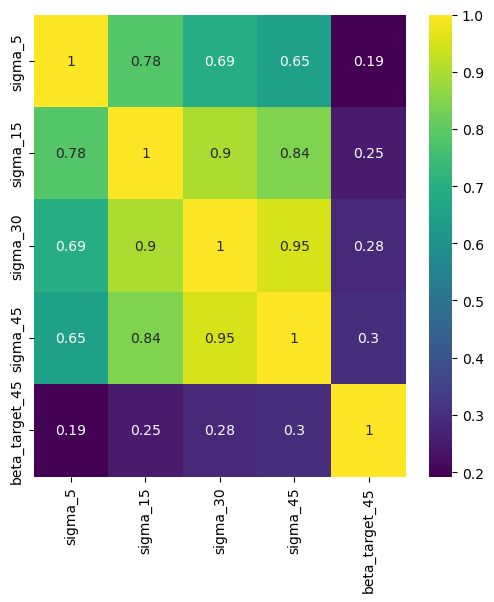

In [21]:
feature_heatmap([f'sigma_{i}' for i in feature_window_span])
# beta_feature_scatter('sigma_45')
# feature_scatter('sigma_45', 'beta_target_45')

* The longer the averaging window of the feature, the stronger the correlation

## Return to spy return ratio

In [22]:
train['sigma_ratio'] = train.groupby('Code', group_keys=False)['sigma_15'].apply(
    lambda x: x/train.loc[1592, 'sigma_15'])
# beta_feature_imp('sigma_ratio')

## Bollinger band feature

In [23]:
def calc_bbands(periods:list, data:pd.DataFrame = None):
    if data == None: data = train
    for p in periods:
        bbmid_col = f'sma_{p}'
        data[bbmid_col] = data.groupby('Code')['cum_return'].rolling(p).mean().droplevel(0)
        bb_std = data.groupby('Code')['cum_return'].rolling(p).std().droplevel(0)
        data[f'bbhigh_{p}'] = data[bbmid_col] + 2*bb_std
        data[f'bblow_{p}'] = data[bbmid_col] - 2*bb_std
        data[f'bbceil_{p}'] = 1-data['cum_return']/data[f'bbhigh_{p}']
        data[f'bbfloor_{p}'] = 1-data[f'bblow_{p}']/data['cum_return']
        # data[f'bbdiff_{p}'] = data[f'bbceil_{p}']+data[f'bbfloor_{p}']

calc_bbands(feature_window_span)
train

RowId    Open    High     Low   Close  Volume  \
Code Date                                                                
1301 2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   31400   
     2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   17900   
     2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   19900   
     2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   24200   
     2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0    9300   
...                        ...     ...     ...     ...     ...     ...   
9997 2021-11-29  20211129_9997   678.0   679.0   665.0   668.0  320800   
     2021-11-30  20211130_9997   670.0   689.0   667.0   667.0  296300   
     2021-12-01  20211201_9997   661.0   688.0   660.0   685.0  339100   
     2021-12-02  20211202_9997   681.0   692.0   680.0   684.0  342900   
     2021-12-03  20211203_9997   690.0   711.0   686.0   696.0  381100   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1301 2017-01-04               1.0               NaN            False   
     2017-01-05               1.0               NaN            False   
     2017-01-06               1.0               NaN            False   
     2017-01-10               1.0               NaN            False   
     2017-01-11               1.0               NaN            False   
...                           ...               ...              ...   
9997 2021-11-29               1.0               NaN            False   
     2021-11-30               1.0               NaN            False   
     2021-12-01               1.0               NaN            False   
     2021-12-02               1.0               NaN            False   
     2021-12-03               1.0               NaN            False   

                   Target  ...    sma_30  bbhigh_30  bblow_30  bbceil_30  \
Code Date                  ...                                             
1301 2017-01-04  0.000730  ...       NaN        NaN       NaN        NaN   
     2017-01-05  0.002920  ...       NaN        NaN       NaN        NaN   
     2017-01-06 -0.001092  ...       NaN        NaN       NaN        NaN   
     2017-01-10 -0.005100  ...       NaN        NaN       NaN        NaN   
     2017-01-11 -0.003295  ...       NaN        NaN       NaN        NaN   
...                   ...  ...       ...        ...       ...        ...   
9997 2021-11-29  0.026987  ...  0.949491   1.063840  0.835141   0.220418   
     2021-11-30 -0.001460  ...  0.942621   1.060616  0.824625   0.219219   
     2021-12-01  0.017544  ...  0.936454   1.053709  0.819200   0.192892   
     2021-12-02  0.014368  ...  0.930454   1.046479  0.814428   0.188503   
     2021-12-03  0.018414  ...  0.925363   1.039086  0.811641   0.168390   

                 bbfloor_30    sma_45  bbhigh_45  bblow_45  bbceil_45  \
Code Date                                                               
1301 2017-01-04         NaN       NaN        NaN       NaN        NaN   
     2017-01-05         NaN       NaN        NaN       NaN        NaN   
     2017-01-06         NaN       NaN        NaN       NaN        NaN   
     2017-01-10         NaN       NaN        NaN       NaN        NaN   
     2017-01-11         NaN       NaN        NaN       NaN        NaN   
...                     ...       ...        ...       ...        ...   
9997 2021-11-29   -0.006982  0.979219   1.106390  0.852047   0.250399   
     2021-11-30    0.004207  0.974059   1.106506  0.841612   0.251600   
     2021-12-01    0.036753  0.969341   1.103970  0.834713   0.229637   
     2021-12-02    0.040964  0.965010   1.102310  0.827710   0.229604   
     2021-12-03    0.060725  0.960982   1.099268  0.822695   0.213919   

                 bbfloor_45  
Code Date                    
1301 2017-01-04         NaN  
     2017-01-05         NaN  
     2017-01-06         NaN  
     2017-01-10         NaN  
     2

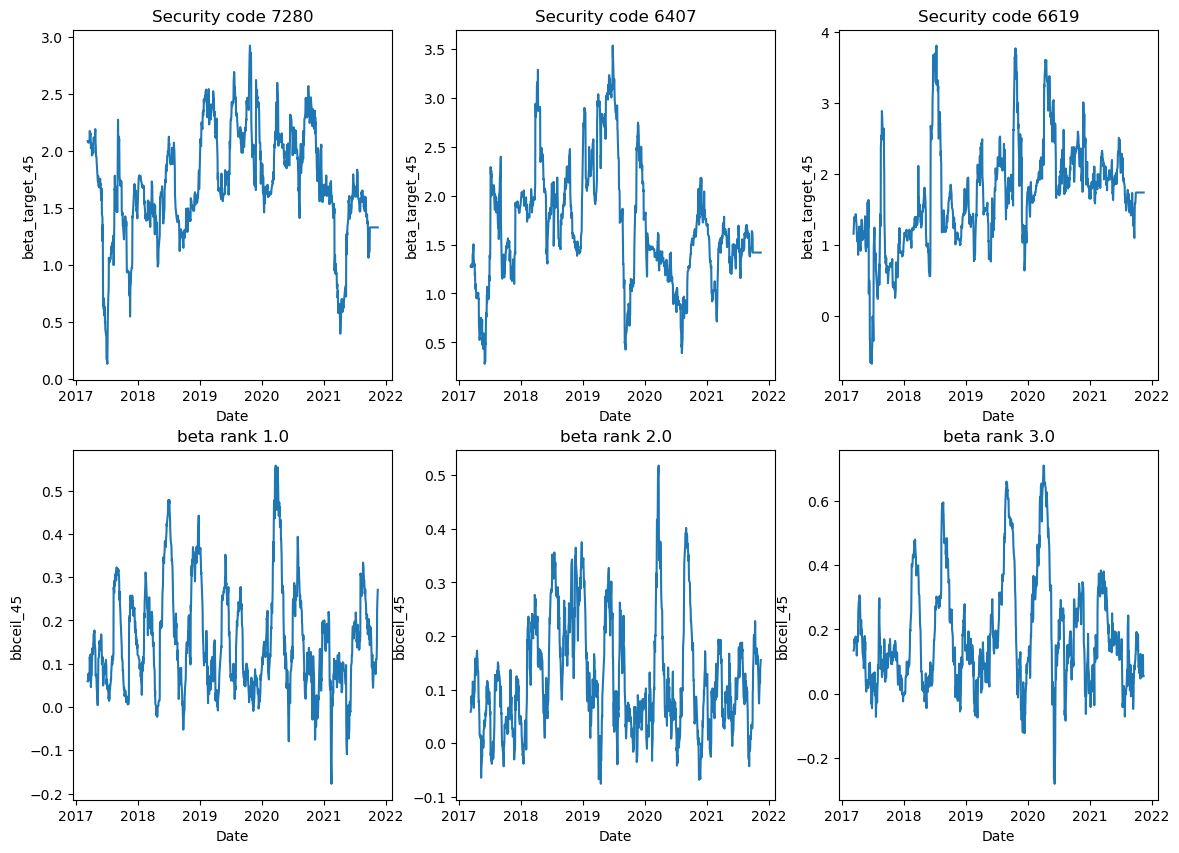

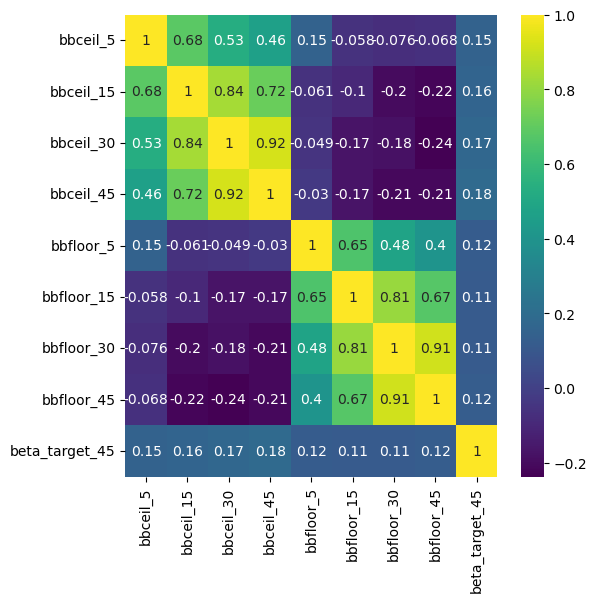

In [39]:
feature_timeseries_plot(top3_betas, 'bbceil_45', 'beta_target_45')

bb_feats = [f'bbceil_{i}' for i in feature_window_span]+[f'bbfloor_{i}' for i in feature_window_span]#+[f'bbdiff_{i}' for i in feature_window_span]
feature_heatmap(bb_feats, targets = ['beta_target_45'])

## ATR features

In [25]:
train['ATR_1'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_2'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Open'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_3'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['Open'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)

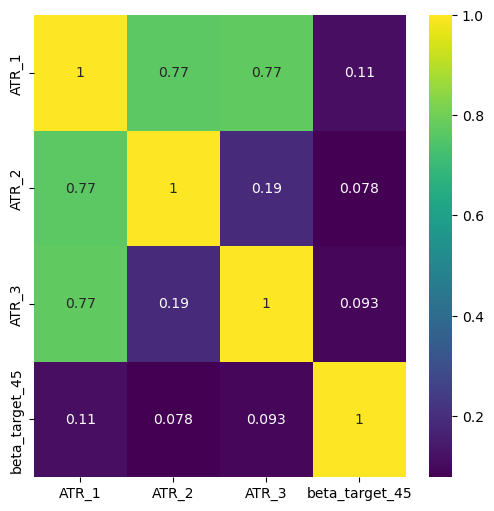

In [26]:
feature_heatmap(['ATR_1', 'ATR_2', 'ATR_3'])

market index has already been removed


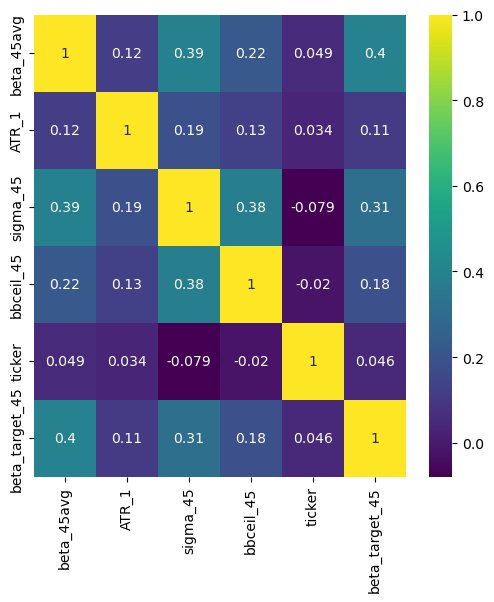

In [43]:
train['ticker'] = train.index.get_level_values(0)
train['month'] = train.index.get_level_values(1).month 
train['week'] = train.index.get_level_values(1).isocalendar().week.values
atr_feats = [f'ATR_{i+1}' for i in range(3)]
vol_feats = [f'sigma_{i}' for i in feature_window_span]

# cat_feats = ['ticker', 'month', 'week']
cat_feats =['ticker']
train[cat_feats] = train[cat_feats].astype('category')

custom_picked_feats = [
    'beta_45avg', 
    'ATR_1', 
    'sigma_45',
    'bbceil_45', 
    ]


# beta_feature_list = atr_feats+vol_feats+bb_feats +cat_feats
beta_feature_list =custom_picked_feats+cat_feats

target = 'beta_target_45'

feature_heatmap(beta_feature_list, [target])


holdout = 2021


# train['beta'] = np.log1p(train['beta'])
nan_cuttoff_date = '2017-3-10'

try:
    train = train.drop(index=1592, axis=0)
except:
    print('market index has already been removed')
train = train.loc[idx[:, nan_cuttoff_date:'2021-11-15'],:]
X = train.loc[idx[:, '2017':str(holdout-1)], beta_feature_list].copy()
y = train.loc[idx[:, '2017': str(holdout-1)], target].copy()

X_holdout = train.loc[idx[:, str(holdout)], beta_feature_list].copy()
y_holdout = train.loc[idx[:, str(holdout)], target].copy()



# Cross validation scheme

I'll use a custom cross validator from Stefan Jansen's github that accepts a multindex dataframe has a class argument.  
* Leave the most recent year out as a holdout set for evaluation
* I'll make my train period 1 year to capture any seasonal effects, and test on half a year
* Using the time seires walk forward approach, data on January 2017 - December 2021 should yield about **6** training and validation sets with **1** holdout test set on the full year  of 2021

In [30]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(1).unique()
        days = sorted(unique_dates, reverse=True)
        # days = unique_dates
        # days = sorted(unique_dates, reverse=False)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()['Date']
        # self.dates = dates
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates > days[train_start])
                              & (dates <= days[train_end])].index
            test_idx = dates[(dates > days[test_start])
                             & (dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

cv = MultipleTimeSeriesCV(n_splits=6, train_period_length=220-45, test_period_length=110, lookahead=45)

i = 0
for train_idx, test_idx in cv.split(X=X):
    X_train = X.iloc[train_idx]
    train_dates = X_train.index.get_level_values(1)
    X_test = X.iloc[test_idx]
    test_dates = X_test.index.get_level_values(1)
    df = pd.concat((X_train.reset_index(), X_test.reset_index()), axis = 0)
    n = len(df)
    # assert n== len(df.drop_duplicates())
    print(X_train.groupby(level=0).size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          X_test.groupby(level=0).size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break


219 2019-06-20 2020-05-18 110 2020-07-20 2020-12-30
219 2019-01-04 2019-11-28 110 2020-02-06 2020-07-17
219 2018-07-23 2019-06-18 110 2019-08-22 2020-02-05
219 2018-02-09 2018-12-27 110 2019-03-08 2019-08-21
219 2017-08-29 2018-07-19 110 2018-09-21 2019-03-07
219 2017-03-21 2018-02-07 110 2018-04-13 2018-09-20


# Ridge regression

# XGBoost

In [31]:
model_names = [f'model_{i}' for i in range(cv.n_splits)]
metrics_df = pd.DataFrame(
    index = ['rmse', 'mae', 'pearson_r', 'spearman_r']
    , columns = model_names
)
train_predictions = pd.DataFrame(index = X.index.to_numpy(), columns = model_names)

xgb_models = {}
xgb_cv_results = {}

xgb_params = {
    'enable_categorical': True,
    'n_estimators': 3000,
    'verbose': False,
    'early_stopping_rounds': 100,
    'eta': 0.005,
    'objective':'reg:squarederror',
    'verbosity':0,
    'eval_metric': ['rmse', 'mae'],
    'max_depth': 6,#6,
    # 'gamma': 0.5,
    'min_child_weight': 1,
    'booster': 'gbtree',
    'tree_method': 'hist',
    'sampling_method': 'gradient_based',
    'subsample':0.1,
    'colsample_bytree':0.5,
    'colsample_bylevel': 1,
    # 'alpha': 200,#10,
    # 'lambda': 300,#30,
    'device': 'cuda',
}
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    model_no = f'model_{i}'

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(**xgb_params)
    eval_set = (X_test, y_test)
    eval_results = []
    model.fit(
        X = X_train, y= y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    xgb_models[model_no] = model
    xgb_cv_results[model_no] = model.evals_result()

    ypred_test = model.predict(X_test)

    metrics_df.loc['rmse', model_no] = mean_squared_error(y_test, ypred_test, squared=False)
    metrics_df.loc['mae', model_no] = mean_absolute_error(y_test, ypred_test)
    metrics_df.loc['pearson_r', model_no] = pearsonr(y_test, ypred_test)[0]
    metrics_df.loc['spearman_r', model_no] = spearmanr(y_test, ypred_test)[0]
    train_predictions.loc[:, model_no] = model.predict(X)


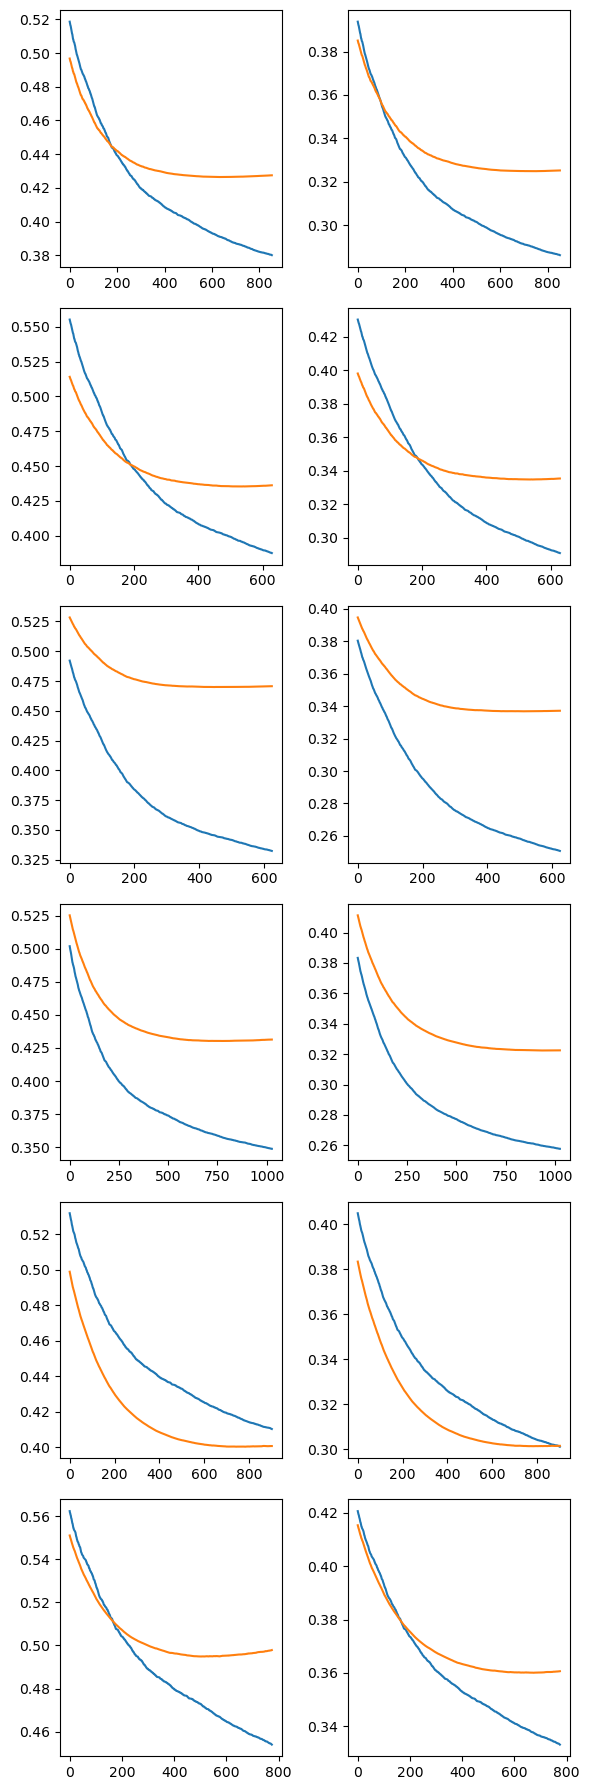

In [32]:
fig, ax = plt.subplots(cv.n_splits, 2, figsize = (3*2, 18), tight_layout = True)
for i, fold_no in enumerate(xgb_cv_results.keys()):

    fold = xgb_cv_results[fold_no]

    for j, set_no in enumerate(fold.keys()):
        set = fold[set_no]
        for k, metric in enumerate(set.keys()):
            data = np.array((set[metric]))
            ax[i, k].plot(data)
            

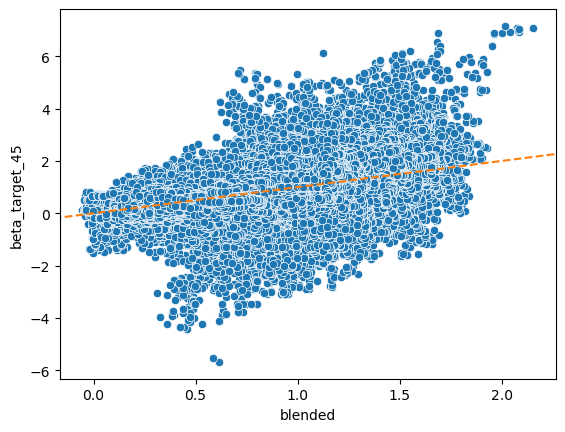

In [33]:
metrics_df.loc['pearson_weight'] = metrics_df.loc['pearson_r']/metrics_df.loc['pearson_r'].sum()
train_predictions['blended'] = (train_predictions*metrics_df.loc['pearson_weight']).sum(axis = 1)

fig, ax = plt.subplots()

sns.scatterplot(x=train_predictions['blended'],y= y)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--',color = 'tab:orange')

In [34]:
pearsonr(train_predictions['blended'], y.dropna())

PearsonRResult(statistic=0.5715469808761031, pvalue=0.0)

,model_0,model_1,model_2,model_3,model_4,model_5
rmse,0.35165,0.346075,0.343762,0.365552,0.362929,0.380395
mae,0.264008,0.258991,0.256732,0.268754,0.270206,0.285687
pearson_r,0.560338,0.574961,0.577826,0.529376,0.51404,0.420949
spearman_r,0.575808,0.58475,0.583295,0.55313,0.540431,0.46435
pearson_weight,0.176346,0.180948,0.18185,0.166602,0.161776,0.132479


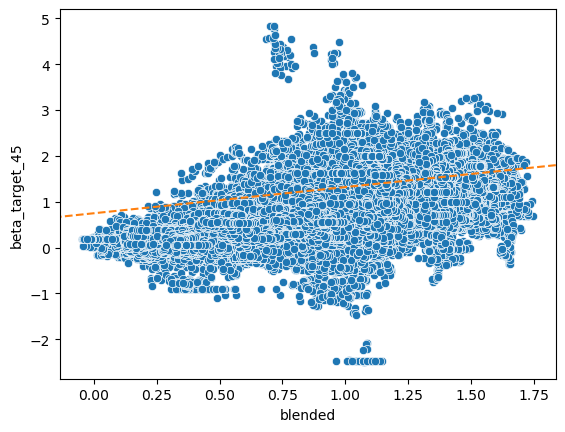

In [35]:
holdout_predictions = pd.DataFrame(columns = model_names, index = y_holdout.index)
holdout_metrics = pd.DataFrame(index = metrics_df.index, columns =metrics_df.columns)
for key in xgb_models.keys():
    model = xgb_models[key]
    ypred = model.predict(X_holdout)
    holdout_predictions[key] = ypred

    holdout_metrics.loc['rmse', key] = mean_squared_error(ypred, y_holdout, squared=False)
    holdout_metrics.loc['mae', key] = mean_absolute_error(ypred, y_holdout)
    holdout_metrics.loc['pearson_r', key] = pearsonr(ypred, y_holdout)[0]
    holdout_metrics.loc['spearman_r', key] = spearmanr(ypred, y_holdout)[0]

holdout_metrics.loc['pearson_weight']= holdout_metrics.loc['pearson_r']/holdout_metrics.loc['pearson_r'].sum()
display(holdout_metrics)

holdout_predictions['blended'] = (holdout_predictions*holdout_metrics.loc['pearson_weight']).sum(axis=1)

fig, ax = plt.subplots()

sns.scatterplot(x=holdout_predictions['blended'],y= y_holdout)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y_holdout.min(), y_holdout.max()], '--',color = 'tab:orange')

In [36]:
pearsonr(holdout_predictions['blended'], y_holdout)

PearsonRResult(statistic=0.6039121791363362, pvalue=0.0)

# Analyze a few time series

In [37]:
# ticker = 4628
# df = pd.concat([train, holdout_predictions], axis = 1).loc[idx[ticker, str(holdout)]]
# fig, ax = plt.subplots()

# sns.lineplot(df, x = 'Date', y= 'beta', ax = ax)
# sns.lineplot(df, x = 'Date', y = 'blended', ax = ax)